<hr style="border:2px solid #0281c9"> </hr>

<img align="left" alt="ESO Logo" src="http://archive.eso.org/i/esologo.png">  

<div align="center">
  <h1 style="color: #0281c9; font-weight: bold;">ESO Science Archive</h1> 
  <h2 style="color: #0281c9; font-weight: bold;">Jupyter Notebooks</h2>
</div>

<hr style="border:2px solid #0281c9"> </hr>

# **Exploring the MUSE View of NGC 253**

This notebook demonstrates how to access and explore MUSE observations of the nearby starburst galaxy NGC 253, released as part of the **first public data release of The MUSE View of the Sculptor** programme. The primary data product is a **364 GB (339 GiB)** MUSE mosaic data cube — the largest optical integral field dataset ever released for a nearby galaxy. Rather than downloading the full cube, this notebook shows how to programmatically request **cutouts** — small, spatially and/or spectrally cropped subsets of the full dataset — via ESO’s Science Archive Facility.

---

### 🗂️ **Data Products**

This release consists of a [Phase 3 validated science product](https://www.eso.org/sci/observing/phase3.html), part of the [108.2289](https://archive.eso.org/scienceportal/home?data_collection=108.2289) data collection (DOI: [10.18727/archive/100](https://doi.org/10.18727/archive/100)). It is a **community-delivered, ESO-ingested dataset** available via the Science Archive Facility:


- 📦 [ADP.2025-07-06T07:52:11.871](https://archive.eso.org/dataset/ADP.2025-07-06T07:52:11.871): full-resolution MUSE mosaic data cube preview
- 📊 [Ancillary DAP maps (~10 GB)](https://dataportal.eso.org/dataPortal/file/ADP.2025-07-06T07:52:11.876): emission-line fluxes (e.g. Hα, [N II], [S II]), stellar and gas kinematics, moment maps  
- 📝 [Official data release description](https://www.eso.org/rm/api/v1/public/releaseDescriptions/236): documentation for the Phase 3 collection
- 📰 [ESO press release (eso2510)](https://www.eso.org/public/news/eso2510/): media highlights from eso  

---

### 🌀 **Dataset Overview**

The mosaic was built from 103 individual MUSE pointings in Wide Field Mode (WFM) with extended wavelength coverage. Most pointings (101) were taken without adaptive optics (AO), with approx 850 s exposure times. Two central pointings covering the nuclear region used AO and longer integrations (appox 2000 s), providing higher spatial resolution across the starburst core. The final mosaic spans approximately **20 × 5 arcminutes**, and provides a richly detailed view of the ionised gas, stellar populations, and dust in this prototypical Sculptor group galaxy.

<p align="center">
  <img src="https://cdn.eso.org/images/screen/eso2510a.jpg" alt="MUSE View of NGC 253" width="1000"/>
  <img src="https://cdn.eso.org/images/screen/eso2510b.jpg" alt="MUSE View of NGC 253" width="1000"/>
  <br>
  <em>Figure: MUSE view of the Sculptor galaxy NGC 253, and its ionised gas (Credit: ESO/E. Congiu et al.)</em>
</p>

---

### ✂️ **What’s a Cutout?**

Given the large file size, downloading the full cube is often impractical. Instead, this notebook shows how to retrieve **cutouts**: cropped subsets of the data cube, still in standard FITS format. These can be selected in:

- **Spatial** coordinates (RA, Dec)
- **Spectral** range (wavelength)
- Or both

Cutouts allow efficient exploration of targeted regions or specific emission lines without transferring hundreds of gigabytes.

---

### 💻 **How to Use This Notebook**

You can view this notebook as a static HTML page or run it interactively via [Jupyter](https://jupyter.org/install). It’s also available, alongside other examples, on the ESO [programmatic access page](https://archive.eso.org/programmatic/#SCRIPT).

To interact with the notebook:

- Navigate cells with the arrow keys  
- Execute a cell with `Ctrl+Enter` or `Cmd+Enter` (on Mac)  
- Modify and re-run code to explore custom regions or lines

---

### ⚠️ **Known Issue with Large Requests**

> **Note:** If you receive a timeout error when making a cutout request, this is expected behavior given the size of the dataset. Please try again — depending on server load, it may take several retries before succeeding. We are actively investigating ways to improve responsiveness for exceptionally large data products like this one.
<hr style="border:2px solid #0281c9"> </hr>

## **Importing the necessary modules**

In [1]:
import requests # For making HTTP requests
import cgi # For making HTTP requests and handling multipart form data

from tqdm import tqdm # For displaying progress bars during downloads
import numpy as np  # Numerical operations and array handling
from matplotlib import pyplot as plt  # Plotting library for visualizations

from astropy.coordinates import SkyCoord  # Celestial coordinate handling and conversions
from astropy import units as u  # Physical units and quantities
from astropy.wcs import WCS  # World Coordinate System handling for celestial coordinates
from astropy.io import fits  # FITS file handling for astronomical data

## **Define some useful functions** 

Let's define a couple of utility functions, useful to write the files on disk.

In [2]:
def getDispositionFilename(response):
    """Get the filename from the Content-Disposition in the response's http header"""
    contentdisposition = response.headers.get('Content-Disposition')
    if contentdisposition == None:
        return None
    value, params = cgi.parse_header(contentdisposition)
    filename = params["filename"]
    return filename
    
def download_with_progress(url, timeout=600):
    """Download a file with a progress bar using streaming."""
    response = requests.get(url, stream=True, timeout=timeout)
    if response.status_code != 200:
        raise RuntimeError(f"Download failed with status code {response.status_code} -- Please try again...")

    # Get the filename from the header
    filename = getDispositionFilename(response)
    if filename is None:
        filename = url.split("/")[-1]

    # Get file size (in bytes) from header
    total_size = int(response.headers.get('Content-Length', 0))
    block_size = 1024  # 1 KiB

    # Download with progress bar
    with open(filename, 'wb') as f, tqdm(
        total=total_size, unit='iB', unit_scale=True, desc="Downloading", ncols=80
    ) as bar:
        for data in response.iter_content(block_size):
            f.write(data)
            bar.update(len(data))

    return filename

And also lets then define a function to get a cutout from the ESO Data Portal. This function will take parameters such as data product ID (dp_id - in the form of e.g. ADP.2025-07-06T07:52:11.871), coordinates (RA and Dec), radius, wavelength range, prefix, verbosity, and whether to download the data or not.

In [3]:
def get_cutout(dp_id, ra, dec, radius, wave_min=None, wave_max=None, prefix=None, verbose=False, download=True): 
    """Get a cutout from the ESO Data Portal. 
    """
    base_url = "https://dataportal.eso.org/dataPortal/soda/sync?ID="

    radius = np.round(radius, 6)  # Round to 6 decimal places for precision
    circle = f"CIRCLE={ra}+{dec}+{radius}" 
    band   = f"BAND={wave_min}+{wave_max}" if wave_min and wave_max else ""
    prefix = f"PREFIX={prefix}" if prefix else ""
    file_url = f"{base_url}{dp_id}&{prefix}&{circle}&{band}"

    if verbose:
        print("Requesting cutout from URL: %s" % (file_url))

    if not download:
        print("Skipping download (set download=True), returning file URL.")
        return file_url
    else:
        print("Querying file: %s" % (dp_id))
        filename = download_with_progress(file_url)

    return filename  # Return the filename for further processing if needed

And a simple function to open the FITS file and return the HDU list, which can be used to inspect the contents of the FITS file.

In [4]:
def open_cutout(filename):
    """Open the FITS file and return the HDU list"""
    try:
        hdul = fits.open(filename)
        return hdul
    except Exception as e:
        print(f"Error opening file {filename}: {e}")
        return None

## **Retrieve the NGC 253 dataset**

### **Get Halpha Spectrum and Map towards centre of NGC253**
Firstly lets download part of the NGC 253 dataset towards the centre of the galaxy and check what the Halpha emission looks like, both spectrally and spatially. We start by resolving the target coordinates, and defining the cutout region we would like.... 

In [5]:
target = "NGC253" # The target galaxy NGC 253
dp_id = "ADP.2025-07-06T07:52:11.871" # Data product ID for the NGC 253 dataset

In [6]:
coords = SkyCoord.from_name(target) # Convert target name to coordinates
ra = coords.ra.deg # Right Ascension in degrees
dec = coords.dec.deg # Declination in degrees
# radius = (60*u.arcsec).to("deg").value # Radius in degrees
radius = (360*u.arcsec).to("deg").value # Radius in degrees

wave_min = 652e-9  # Minimum wavelength in meters
wave_max = 662e-9  # Maximum wavelength in meters

#### **Get cutout of from the ESO Data Portal** 
Now we use the `get_cutout` function to retrieve a 60 arcsec cutout of the data cube around our (central) position, and around the Halpha+[NII] line (as defined above). 

In [7]:
# Get the cutout from the ESO Data Portal
# filename = get_cutout(dp_id, ra, dec, radius, wave_min=wave_min, wave_max=wave_max)
filename = get_cutout(dp_id, ra, dec, radius, wave_min=wave_min, wave_max=wave_max, verbose=True)

# Open the cutout FITS file and return the HDU list
hdul = open_cutout(filename)

Querying file: ADP.2025-07-06T07:52:11.871


Downloading: 100%|████████████████████████| 4.55G/4.55G [09:21<00:00, 8.10MiB/s]


> **Note:** If you receive a timeout error when making the above call, this is normal for such a large dataset. Please try again — depending on server traffic, it can take several retries before succeeding.

#### **Extract downloaded data** 

First, we make a small function to get the wavelength axis from the FITS file, which will be useful for plotting the spectral data.

In [8]:
def get_wavelengthaxis(hdul):
    """Extract wavelength axes from the HDU list"""
    hdr = hdul[1].header
    crval = hdr["CRVAL3"]
    cdelt = hdr["CD3_3"]
    crpix = hdr["CRPIX3"]
    naxis = hdr["NAXIS3"]
    wave = crval + (np.arange(naxis) + 1 - crpix) * cdelt
    return wave

In [9]:
data = hdul[1].data # Get image data from the second HDU
data_wave = get_wavelengthaxis(hdul) # Get the wavelength axes from the FITS file
data_cont = np.nanmedian(data, axis=0) # Median over the spectral dimension to get the (approximate) continuum map
data_line = np.nansum(data - data_cont, axis=0)  # Subtract the continuum to get the line map and sum over the spectral dimension
data_spec = np.nanmean(data - data_cont, axis=(1,2))  # Subtract the continuum to get the line map and average over the spatial dimensions

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_30123/2887794629.py:3: RuntimeWarning: All-NaN slice encountered
  data_cont = np.nanmedian(data, axis=0) # Median over the spectral dimension to get the (approximate) continuum map


#### **Plot downloaded data (spectrum)** 
Plot the spectrum of the Halpha emission line, which is the average over the spatial dimensions and continuum subtracted.

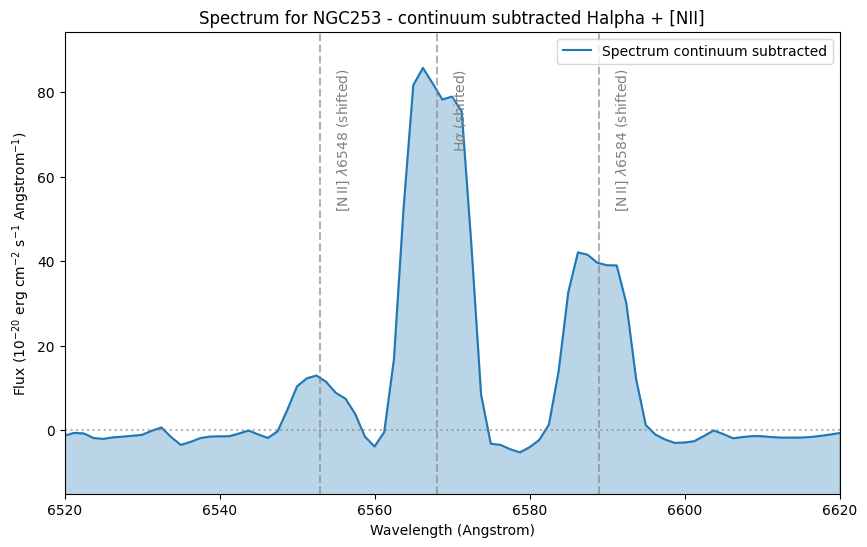

In [10]:
# Define key emission lines in Angstrom
lines = {
    r'[N II] $\lambda6548$': 6548,
    r'H$\alpha$': 6563,
    r'[N II] $\lambda6584$': 6584,
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(data_wave, data_spec, label='Spectrum continuum subtracted')
ax.fill_between(data_wave, -20, data_spec, where=(data_spec > -20), alpha=0.3, color='C0')
ax.hlines(0, data_wave[0], data_wave[-1], color='gray', linestyle=':', alpha=0.6)


# Add vertical lines and labels for key lines
for label, wave in lines.items():
    if ax.get_xlim()[0] < wave < ax.get_xlim()[1]:  # Only show if within plotting range
        ax.axvline(wave+5, color='gray', linestyle='--', alpha=0.6)
        ax.text(wave + 7, np.nanmax(data_spec), 
                label+' (shifted)', 
                rotation=90, verticalalignment='top', fontsize=10, color='gray')

ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (10$^{-20}$ erg cm$^{-2}$ s$^{-1}$ Angstrom$^{-1}$)')
ax.set_title(f'Spectrum for {target} - continuum subtracted Halpha + [NII]')

ax.set_ylim(-15, np.nanmax(data_spec) * 1.1)  # Set y-limits to avoid clipping
ax.set_xlim(6520, 6620)

ax.legend()

#### **Plot downloaded data (map)** 

Plot the maps of the Halpha + [NII] emission and the continuum, which are the sum and median over the spectral dimension, respectively.

We also mark the position of interest on both maps - for which we will extract the full spectrum in the next step (note, aperture not to scale).

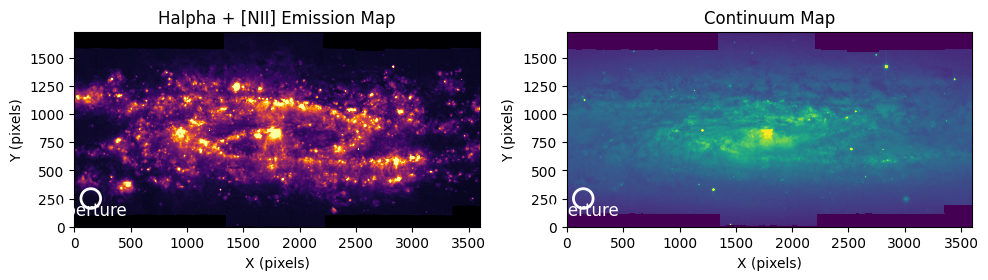

In [11]:
pos = [145, 250]

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

map1 = np.sqrt(np.abs(data_line)) # included abs here to avoid error on sqrt of negative values
map2 = np.sqrt(np.abs(data_cont))

cmap1 = plt.cm.inferno
cmap2 = plt.cm.viridis
cmap1.set_bad(color=cmap1(0))
cmap2.set_bad(color=cmap2(0))

ax1.imshow(map1, origin='lower', cmap=cmap1, vmin=np.nanpercentile(map1, 0), vmax=np.nanpercentile(map1, 99.1))
ax2.imshow(map2, origin='lower', cmap=cmap2, vmin=0, vmax=np.nanpercentile(map2, 99.9))

ax1.scatter(pos[0], pos[1], color='white', marker='o', s=200, lw=2, fc='none')
ax2.scatter(pos[0], pos[1], color='white', marker='o', s=200, lw=2, fc='none')

ax1.text(pos[0], pos[1] - 20, 'Aperture', color='white', fontsize=12, ha='center', va='top')
ax2.text(pos[0], pos[1] - 20, 'Aperture', color='white', fontsize=12, ha='center', va='top')

ax1.set_title('Halpha + [NII] Emission Map')
ax2.set_title('Continuum Map')
ax1.set_xlabel('X (pixels)')
ax2.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax2.set_ylabel('Y (pixels)')

fig.tight_layout()

### **Get the full spectrum at the position of interest (e.g. HII region)**
Now we can extract the full spectrum at the position of interest, which is the position of the HII region in NGC 253. 

First need need to get the real world position of the aperture (see maps above), which is used to extract the spectrum.

In [12]:
wcs = WCS(hdul[1].header)
coords = wcs.pixel_to_world(pos[0], pos[1], 0)[0]
print(f"Position in sky coordinates: {coords.to_string('decimal')} degrees")
print(f"Position in sky coordinates: {coords.to_string('hmsdms')}")
print(f"Position in pixel coordinates: {pos[0]}, {pos[1]}")

ra = coords.ra.deg # Right Ascension in degrees
dec = coords.dec.deg # Declination in degrees
radius = (1*u.arcsec).to("deg").value # Radius in degrees

Position in sky coordinates: 11.8974 -25.2855 degrees
Position in sky coordinates: 00h47m35.37532805s -25d17m07.84008262s
Position in pixel coordinates: 145, 250


Then, as before, we use our `get_cutout` function to retrieve the full spectrum at that position (note the lack of constraints on `wave_min` and `wave_max`, which means we get the full spectral cutout), also note here we extract a small cutout of only 1 arcsec radius (approx a single psf for these data) that we will average over the spatial dimensions to get the full spectrum.

In [14]:
# Get the cutout from the ESO Data Portal
filename = get_cutout(dp_id, ra, dec, radius) # Given no constraints on wavelength, we get the full cutout

# Open the cutout FITS file and return the HDU list
hdul = open_cutout(filename)

Querying file: ADP.2025-07-06T07:52:11.871


Downloading: 100%|████████████████████████| 3.53M/3.53M [00:00<00:00, 26.5MiB/s]


> **Note:** If you receive a timeout error when making the above call, this is normal for such a large dataset. Please try again — depending on server traffic, it can take several retries before succeeding.

As before, we extract the spectrum... 

In [15]:
data = hdul[1].data # Get image data from the second HDU
data_wave = get_wavelengthaxis(hdul) # Get the wavelength axes from the FITS file
masked_data = np.ma.masked_invalid(data) # mask invalid values in the data (possible that some channels have all NaN values)
data_spec = masked_data.mean(axis=(1, 2)).filled(np.nan)

And finally plot the full spectrum, on which we label a number of important emission lines. 

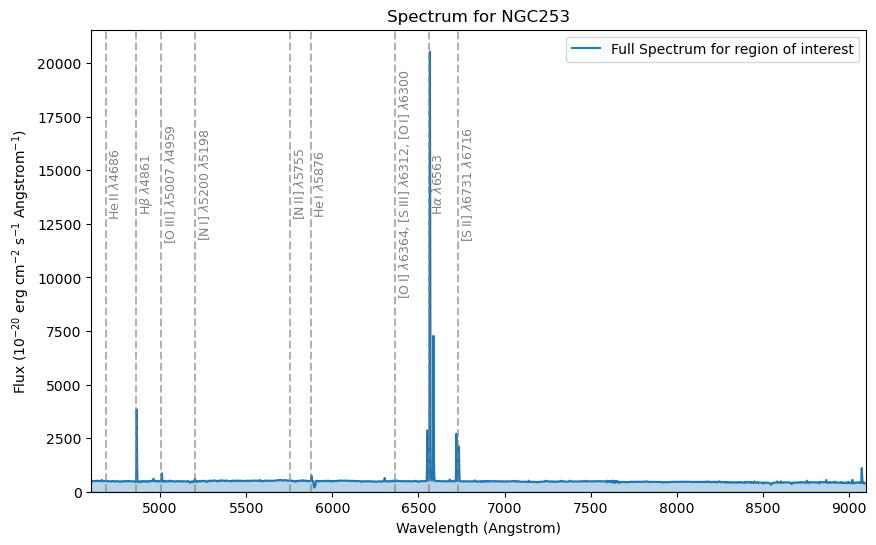

In [16]:
# Define some key emission lines in Angstrom
lines = {
    r'He II $\lambda$4686': 4686,
    r'H$\beta$ $\lambda$4861': 4861,
    # r'[O III] $\lambda$4959': 4959,
    r'[O III] $\lambda$5007 $\lambda$4959': 5007,
    # r'[N I] $\lambda$5198': 5198,
    r'[N I] $\lambda$5200 $\lambda$5198': 5200,
    r'[N II] $\lambda$5755': 5755,
    r'He I $\lambda$5876': 5876,
    # r'[O I] $\lambda$6300': 6300,
    # r'[S III] $\lambda$6312': 6312,
    r'[O I] $\lambda$6364, [S III] $\lambda$6312, [O I] $\lambda$6300': 6364,
    # r'[N II] $\lambda$6548': 6548,
    r'H$\alpha$ $\lambda$6563': 6563,
    # r'[N II] $\lambda$6584': 6584,
    # r'[S II] $\lambda$6716': 6716,
    r'[S II] $\lambda$6731 $\lambda$6716': 6731,
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(data_wave, data_spec, label='Full Spectrum for region of interest')
ax.fill_between(data_wave, 0, data_spec, where=(data_spec > 0), alpha=0.3, color='C0')

# Add vertical lines and labels for key lines
for label, wave in lines.items():
    if ax.get_xlim()[0] < wave < ax.get_xlim()[1]:  # Only show if within plotting range
        ax.axvline(wave, color='gray', linestyle='--', alpha=0.6)
        ax.text(wave + 12, np.nanmax(data_spec) * 0.7, label, rotation=90,
                verticalalignment='center', fontsize=9, color='gray')

ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (10$^{-20}$ erg cm$^{-2}$ s$^{-1}$ Angstrom$^{-1}$)')
ax.set_title(f'Spectrum for {target}')

ax.set_ylim(0, np.nanmax(data_spec) * 1.05)  # Set y-limits to avoid clipping
ax.set_xlim(4600, 9100)

ax.legend()

<hr style="border:2px solid #0281c9"> </hr>